Import Kebutuhan

In [28]:
import tensorflow as tf
import scipy 
from tensorflow import keras
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tensorflow.keras.metrics import *
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import average_precision_score
import time

Mempersiapkan data gambar untuk pelatihan, validasi, dan pengujian . Serta pengubahan gambar dari RGB ke Grayscale

In [29]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True,
    #fill_mode='nearest',
    validation_split=0.3  
)

batch_size = 32
image_size = (300, 200)

#training
train_set = train_datagen.flow_from_directory(
    './fundsrgb/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    #color_mode='grayscale',
    subset='training'  
)

#validasi
validation_set = train_datagen.flow_from_directory(
    './fundsrgb/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    #color_mode='grayscale',
    subset='validation'  
)

#test
test_set = train_datagen.flow_from_directory(
    './fundsrgb/test',
    target_size=image_size,  
    batch_size=batch_size,
    class_mode='categorical',
    #color_mode='grayscale',
    shuffle=False
)


Found 843 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


Mengecek Label dan Jumlah Gambar

In [30]:

train_class_counts = dict(zip(train_set.class_indices, [0]*len(train_set.class_indices)))
for filename in train_set.filenames:
    label = filename.split(os.path.sep)[0]
    train_class_counts[label] += 1


validation_class_counts = dict(zip(validation_set.class_indices, [0]*len(validation_set.class_indices)))
for filename in validation_set.filenames:
    label = filename.split(os.path.sep)[0]
    validation_class_counts[label] += 1


print(train_class_counts)
print(validation_class_counts)

{'1_normal': 210, '2_cataract': 210, '2_glaucoma': 213, '3_retina_disease': 210}
{'1_normal': 90, '2_cataract': 90, '2_glaucoma': 90, '3_retina_disease': 90}


Pembuatan Model EfficientNetB3

In [32]:
main_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_tensor=Input(shape=(*image_size, 3))
)

x = GlobalAveragePooling2D()(main_model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

model = Model(main_model.input, output)

for layer in main_model.layers:
    layer.trainable = False

Pembuatan parameter untuk compile model saat pelatihan

In [33]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

Callbacks yang berisikan EarlyStopping

In [34]:
es = EarlyStopping(patience=3, monitor='val_loss')

Pelatihan Model

In [35]:
start_time = time.time()
epochs = 20
model_train = model.fit(
    train_set,
    validation_data=validation_set, 
    epochs=epochs,
    callbacks=[es],
    verbose=1
)

end_time = time.time()
timesec = end_time - start_time
timemin = timesec / 60.0
print(f"Waktu Selesai {timemin} Menit")

Epoch 1/20
27/27 [==============================] - 159s 6s/step - loss: 4.8188 - accuracy: 0.4199 - precision_1: 0.4401 - recall_1: 0.3440 - val_loss: 1.2173 - val_accuracy: 0.4111 - val_precision_1: 0.4769 - val_recall_1: 0.2861
Epoch 2/20
27/27 [==============================] - 153s 6s/step - loss: 0.8576 - accuracy: 0.6145 - precision_1: 0.7279 - recall_1: 0.5077 - val_loss: 1.1625 - val_accuracy: 0.5111 - val_precision_1: 0.5478 - val_recall_1: 0.4139
Epoch 3/20
27/27 [==============================] - 154s 6s/step - loss: 0.7045 - accuracy: 0.7319 - precision_1: 0.7941 - recall_1: 0.6406 - val_loss: 1.2172 - val_accuracy: 0.4722 - val_precision_1: 0.5155 - val_recall_1: 0.4167
Epoch 4/20
27/27 [==============================] - 153s 6s/step - loss: 0.7079 - accuracy: 0.7177 - precision_1: 0.7667 - recall_1: 0.6548 - val_loss: 1.4804 - val_accuracy: 0.4500 - val_precision_1: 0.4806 - val_recall_1: 0.3778
Epoch 5/20
27/27 [==============================] - 154s 6s/step - loss: 0.6

In [36]:
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_set.classes, y_pred)

7/7 [==============================] - 27s 4s/step


Confusion Matrix dan Uji akurasi

In [37]:
class_report = classification_report(test_set.classes, y_pred, target_names=train_set.class_indices.keys())
print(class_report)

                  precision    recall  f1-score   support

        1_normal       0.52      0.32      0.40        50
      2_cataract       0.78      0.80      0.79        50
      2_glaucoma       0.50      0.84      0.63        50
3_retina_disease       0.65      0.44      0.52        50

        accuracy                           0.60       200
       macro avg       0.61      0.60      0.58       200
    weighted avg       0.61      0.60      0.58       200



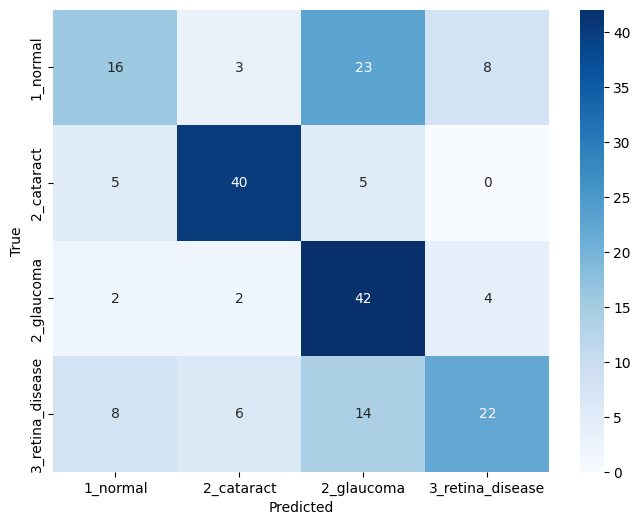

In [38]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_set.class_indices, yticklabels=train_set.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

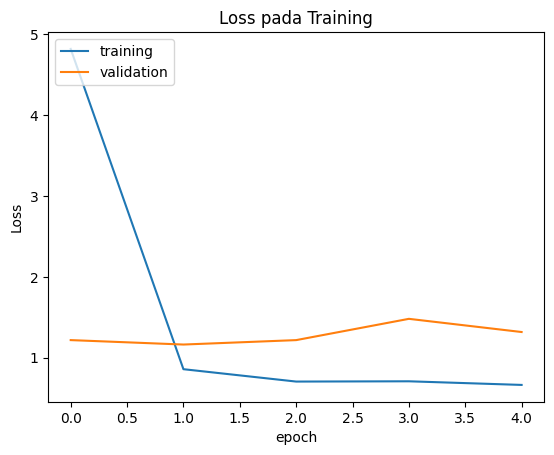

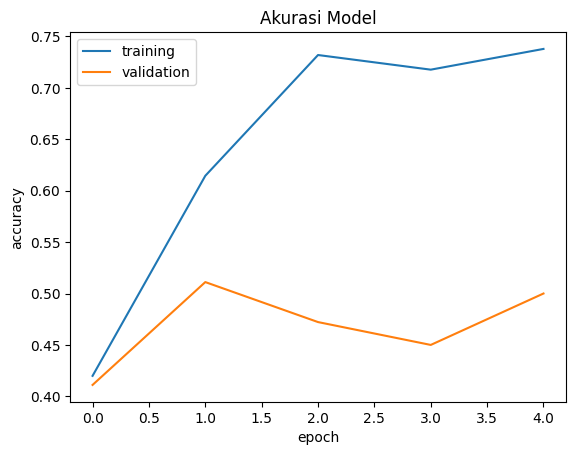

In [39]:
#loss training
plt.plot(model_train.history['loss'], label='Loss (training data)')
plt.plot(model_train.history['val_loss'], label='Loss (validation data)')
plt.title('Loss pada Training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc="upper left")
plt.show()

#akurasi model
plt.plot(model_train.history['accuracy'])
plt.plot(model_train.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Menyimpan Model yang sudah dilatih

In [47]:
model.save('model fundus rgb')

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Memeasukkan Model yang sudah dilatih

In [41]:
from tensorflow.keras.models import load_model
loaded_model = load_model('model fundus rgb')

Mempersiapkan data gambar untuk pengujian. 

In [42]:
test_datagen = ImageDataGenerator(
    rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True,
    #fill_mode='nearest',
    validation_split=0.3  
)

batch_size = 32
image_size = (300, 200)
#test
testing_set = test_datagen.flow_from_directory(
    './fundsrgb/testing',
    target_size=image_size,  
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 400 images belonging to 4 classes.


Melakukan Pengujian terhadap model

In [44]:
Y_pred = loaded_model.predict(testing_set)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testing_set.classes, y_pred)

13/13 [==============================] - 54s 4s/step


Menampilkan Classifier Report Pengujian

In [45]:
class_report = classification_report(testing_set.classes, y_pred, target_names=testing_set.class_indices.keys())
print(class_report)

                  precision    recall  f1-score   support

        1_normal       0.61      0.45      0.52       100
      2_cataract       0.61      0.86      0.71       100
      2_glaucoma       0.61      0.52      0.56       100
3_retina_disease       0.65      0.65      0.65       100

        accuracy                           0.62       400
       macro avg       0.62      0.62      0.61       400
    weighted avg       0.62      0.62      0.61       400



Menampilkan Confusion Matrix Pengujian

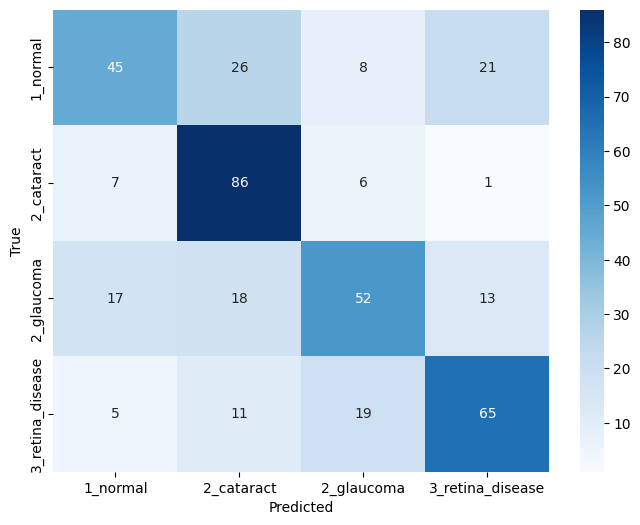

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=testing_set.class_indices, yticklabels=testing_set.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()